# HNSW算法

## 1.HNSW的灵感来源：两大核心思想

HNSW的成功，源于它巧妙地结合了两种经典的思想：
​1.​小世界网络​​：大家可能听过“六度分隔理论”，意思是地球上任何两个人，平均只需要通过六个中间人就能建立起联系。这就是小世界网络的体现
。这种网络的特点是：

- 高聚类性​​：你的朋友之间，彼此也很可能互相是朋友（形成聚集的小团体）。
- 短平均路径​​：尽管有聚集性，但任意两个节点之间的平均距离却很短。HNSW的目标就是构建一个具有类似特性的图，使得可以从任意节点出发，用很少的“步数”（跳跃）到达目标节点。
  ​2.​跳表​​：想象一本有目录的书。目录就是书的“高层结构”，它章节标题，让你能快速定位到大概范围。然后你翻到对应章节，再通过更细的标题或页码找到具体内容。跳表就是类似的多层索引结构，在数据链表上建立多层“快车道”，从高层粗犷检索开始，逐层细化，直到最底层找到目标，从而避免从头到尾的遍历。
  HNSW正是将​​小世界网络​​的连通性和​​跳表​​的分层思想融合在了一起

## 2.算法原理分步详解​

HNSW（**Hierarchical Navigable Small World**，分层可导航小世界图）是一种基于图结构的**近似最近邻（ANN）搜索算法**，  
它通过构建一个多层次的“可导航小世界图”，让搜索过程像“在城市地图中找路”一样高效。

其核心思想是：  

> **先在高层图中快速找到大致方向，再在底层图中精确定位目标。**

下面我们来分步解析 HNSW 的工作原理。

---

### 1.图结构的构建（Index Construction）

HNSW 的核心数据结构是一个**多层图（Hierarchical Graph）**，  
每一层都是一个“小世界网络（Small World Graph）”，即节点之间存在较短的路径连接。

#### 步骤 1：多层结构（层级随机化）

- 每个向量会被随机分配到若干层（Level 0 ~ L）。  
- 层数的分布遵循指数衰减规律（高层节点少，底层节点多）。  
  例如：  
  - Level 3：只有少数节点（类似城市的高速公路网）  
  - Level 2：节点更多（城市主干道）  
  - Level 1：更密集（区级道路）  
  - Level 0：所有节点都在这里（街道级别）

这种结构让算法能像**缩放地图**一样，先看宏观，再聚焦微观。

---

#### 步骤 2：逐层插入节点（Layer-by-Layer Insertion）

当新向量 `v` 进入系统时，HNSW 会逐层插入：

1. **确定插入层级**  
   根据随机分配的层级 `L_v`，决定 `v` 将出现在哪几层。

2. **自顶向下导航**  
   从当前最高层开始，找到与 `v` 最近的节点作为“入口点（Entry Point）”。

3. **逐层下降搜索**  
   在每一层中，执行“贪心搜索（Greedy Search）”：
   - 不断跳向更接近 `v` 的邻居；
   - 当没有更近的节点时，停止；
   - 将当前位置作为下一层的起点。

4. **在对应层建立连接（Linking）**  
   在 `v` 所在的每一层，选取若干最近邻节点建立边连接（邻居数量由参数 `M` 控制）。  
   为保持小世界特性，HNSW 会对邻居集合进行“修剪”，确保网络稀疏且高效。

---

### 2.查询阶段（Search Process）

HNSW 的搜索过程与构建阶段类似，同样遵循“**自顶向下、逐层逼近**”的策略。

#### 步骤 1：从顶层开始搜索

- 选择一个入口节点（通常是构建时的最高层入口点）。  
- 在最高层使用贪心搜索找到与查询向量 `q` 最近的节点。

#### 步骤 2：逐层向下导航

- 将上层搜索到的最优节点作为下一层的入口；
- 在更低层的图中继续搜索，逐步缩小搜索范围；
- 每下一层，节点密度增加，搜索精度提升。

#### 步骤 3：底层精确搜索

- 到达底层（Level 0）后，算法会使用“优先队列 + 局部扩展搜索”策略：  
  - 维护一个候选节点集合（Candidate List）；  
  - 扩展其邻居并更新最近邻；  
  - 重复直到候选集不再变化或达到设定搜索深度（参数 `ef_search`）。  
- 最终返回距离最近的 K 个节点。

---

### 3.关键参数说明

| 参数              | 含义                 | 作用                                 |
| ----------------- | -------------------- | ------------------------------------ |
| `M`               | 每个节点的最大邻居数 | 越大图越稠密，召回率高但内存开销增大 |
| `ef_construction` | 构建阶段的搜索宽度   | 控制索引构建质量与速度               |
| `ef_search`       | 查询阶段的搜索宽度   | 值越大，精度越高但搜索时间更长       |

---

### 4.HNSW 的性能特点

- **高精度**：通过层级导航逐步逼近最优解，近似结果非常接近精确搜索；  
- **高效率**：图结构使得搜索复杂度接近 `O(log N)`；  
- **可增量更新**：新节点可动态插入，无需重建索引；  
- **内存友好**：通过稀疏连接与层级控制，平衡性能与空间。

---

### 5. 类比理解

可以把 HNSW 想象成一场“多层地图找目标”的游戏：

| 层级 | 类比             | 搜索作用         |
| ---- | ---------------- | ---------------- |
| 顶层 | 全国高速公路地图 | 快速确定大致方向 |
| 中层 | 城市主干道地图   | 精确锁定区域     |
| 底层 | 街区地图         | 找到具体目标     |

在搜索过程中，算法像一个熟练的导航员，  
从高速公路（高层）出发，逐层进入城区（低层），最终找到目标建筑（最邻近向量）。

---

**✅ 总结：HNSW 的核心思想**

> **分层导航 + 贪心搜索 + 局部连接优化**

HNSW 通过在不同层次建立稀疏图结构，使搜索可以**先全局定位、再局部精查**，  
在高维向量检索任务中实现了**近似最优的性能与速度平衡**。  
它已成为当前向量数据库（如 **Milvus、FAISS、Weaviate**）中默认启用的主流索引算法。

## 3.HNSW算法实现

🧠 HNSW算法Python实现

### 3.1我们导入必要的库：

In [1]:
import numpy as np
import random
import math
from collections import defaultdict
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
from sklearn.metrics.pairwise import euclidean_distances
import warnings
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.metrics.pairwise import euclidean_distances
import time

# 增强的字体配置（如果上面的字体修复单元已运行，这里会继承配置）
# 如果没有运行字体修复单元，这里提供基础配置
# 强制设置中文字体，解决中文显示问题
plt.rcParams['font.sans-serif'] = ['PingFang SC', 'Microsoft YaHei', 'SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 设置随机种子以保证结果可重现
np.random.seed(41)

### 3.2实现简化的HNSW类

In [2]:
class SimpleHNSW:
    """简化的HNSW实现，用于学习演示"""
    
    def __init__(self, max_elements=1000, M=10, ef_construction=50, max_layers=6):
        """
        初始化HNSW索引
        
        参数:
        - max_elements: 最大元素数量
        - M: 每个节点的最大连接数
        - ef_construction: 构建时的搜索范围
        - max_layers: 最大层数
        """
        self.max_elements = max_elements
        self.M = M  # 每个节点的最大连接数
        self.ef_construction = ef_construction  # 构建时的搜索范围
        self.max_layers = max_layers  # 最大层数
        
        # 存储所有数据点
        self.data_points = []
        # 每层的图结构（邻接表），每层是一个字典，key是节点ID，value是邻居列表
        self.layers = [defaultdict(list) for _ in range(max_layers)]
        # 全局入口点（最高层的节点）
        self.entry_point = None
        self.entry_level = -1  # 入口点所在的最高层级
        
    def _random_level(self):
        """随机生成节点的层级（指数分布）"""
        level = 0
        while random.random() < 0.5 and level < self.max_layers - 1:
            level += 1
        return level
    
    def _euclidean_distance(self, a, b):
        """计算欧氏距离"""
        return np.sqrt(np.sum((a - b) ** 2))
    
    def _search_layer(self, query, entry_point, ef, layer):
        """
        在指定层搜索最近邻
        
        参数:
        - query: 查询向量
        - entry_point: 搜索起始点
        - ef: 搜索范围（返回的候选点数量）
        - layer: 搜索的层级
        """
        if entry_point is None or entry_point not in self.layers[layer]:
            return []
            
        visited = set([entry_point])
        # 候选集：存储(距离, 节点ID)元组，从入口点开始
        candidates = [(self._euclidean_distance(query, self.data_points[entry_point]), entry_point)]
        # 使用堆来维护候选集（这里简化为列表排序）
        results = []
        
        while candidates and len(results) < ef:
            # 获取距离最近的候选点
            candidates.sort(key=lambda x: x[0])
            current_dist, current_point = candidates.pop(0)
            
            # 检查是否应该将当前点加入结果
            if not results or current_dist < results[-1][0]:
                results.append((current_dist, current_point))
                results.sort(key=lambda x: x[0])  # 保持结果按距离排序
                if len(results) > ef:
                    results = results[:ef]  # 限制结果集大小
            
            # 探索当前点的所有邻居节点
            for neighbor in self.layers[layer][current_point]:
                if neighbor not in visited:
                    visited.add(neighbor)
                    dist = self._euclidean_distance(query, self.data_points[neighbor])
                    candidates.append((dist, neighbor))
        
        return results
    
    def add_point(self, point):
        """
        向HNSW中添加新点
        
        参数:
        - point: 要添加的数据点向量
        """
        if len(self.data_points) >= self.max_elements:
            raise ValueError("达到最大容量")
        
        point_id = len(self.data_points)  # 新点在data_points中的id索引
        self.data_points.append(point)
        
        # 确定新点的层级
        level = self._random_level()
        
        # 如果是第一个点，设为入口点
        if self.entry_point is None:
            self.entry_point = point_id
            self.entry_level = level
            for l in range(level + 1):
                self.layers[l][point_id] = []  # 在新点的每一层创建空邻居列表
            return
        
        # 从最高层开始搜索，找到每层的最近邻
        current_point = self.entry_point
        current_max_level = self.entry_level
        
        # 从顶层开始搜索，找到每层的入口点
        for l in range(current_max_level, level, -1):
            if l < len(self.layers):
                results = self._search_layer(point, current_point, 1, l)
                if results:
                    current_point = results[0][1]  # 更新为最近的点
        
        # 从新点的最高层开始，逐层向下插入并建立连接
        for l in range(min(level, current_max_level), -1, -1):
            # 在当前层搜索ef_construction个最近邻
            results = self._search_layer(point, current_point, self.ef_construction, l)
            
            # 选择前M个最近邻作为连接
            neighbors = [idx for _, idx in results[:self.M]]
            
            # 在新点的当前层创建连接
            self.layers[l][point_id] = neighbors.copy()
            
            # 双向连接：邻居也连接到新点
            for neighbor in neighbors:
                if len(self.layers[l][neighbor]) < self.M:
                    # 邻居连接数未满，直接添加
                    self.layers[l][neighbor].append(point_id)
                else:
                    # 如果邻居连接数已满，替换最远的连接
                    neighbor_neighbors = self.layers[l][neighbor]
                    distances = [self._euclidean_distance(self.data_points[neighbor], 
                                                         self.data_points[n]) for n in neighbor_neighbors]
                    max_idx = np.argmax(distances)  # 找到最远的邻居
                    # 如果新点更近，则替换最远的邻居
                    if self._euclidean_distance(self.data_points[neighbor], point) < distances[max_idx]:
                        neighbor_neighbors[max_idx] = point_id
            
            # 更新当前点用于下一层的搜索
            if results:
                current_point = results[0][1]
        
        # 如果新点的层级比当前入口点高，更新入口点
        if level > self.entry_level:
            self.entry_point = point_id
            self.entry_level = level
    
    def search(self, query, k=5, ef_search=50):
        """
        在HNSW中搜索最近邻
        
        参数:
        - query: 查询向量
        - k: 返回的最近邻数量
        - ef_search: 搜索时的候选集大小（越大精度越高但速度越慢）
        
        返回:
        - 包含(节点ID, 距离)的列表，按距离升序排列
        """
        if self.entry_point is None:
            return []
        
        current_point = self.entry_point
        current_level = self.entry_level
        
        # 从顶层开始搜索
        for l in range(current_level, 0, -1):
            results = self._search_layer(query, current_point, 1, l) # 在当前层搜索1个最近邻
            if results:
                current_point = results[0][1]  # 更新为每层的入口点
        
        # 在最底层进行精细搜索
        results = self._search_layer(query, current_point, ef_search, 0)
        
        # 返回前k个结果
        return [(idx, dist) for dist, idx in results[:k]]
    
    def search_with_path(self, query, k=5, ef_search=50):
        """
        在HNSW中搜索最近邻，并记录搜索路径
        
        参数:
        - query: 查询向量
        - k: 返回的最近邻数量
        - ef_search: 搜索时的候选集大小
        
        返回:
        - results: 包含(节点ID, 距离)的列表
        - search_path: 每层的搜索路径字典
        """
        if self.entry_point is None:
            return [], {}
        
        current_point = self.entry_point
        current_level = self.entry_level
        search_path = {}
        
        # 从顶层开始搜索，记录路径
        for l in range(current_level, 0, -1):
            path_nodes = [current_point]
            results = self._search_layer_with_path(query, current_point, 1, l, path_nodes)
            search_path[l] = path_nodes
            if results:
                current_point = results[0][1]  # 更新为每层的入口点
        
        # 在最底层进行精细搜索
        path_nodes = [current_point]
        results = self._search_layer_with_path(query, current_point, ef_search, 0, path_nodes)
        search_path[0] = path_nodes
        
        # 返回前k个结果和搜索路径
        final_results = [(idx, dist) for dist, idx in results[:k]]
        return final_results, search_path
    
    def _search_layer_with_path(self, query, entry_point, ef, layer, path_nodes):
        """
        在指定层搜索最近邻，并记录搜索路径
        
        参数:
        - query: 查询向量
        - entry_point: 搜索起始点
        - ef: 搜索范围
        - layer: 搜索的层级
        - path_nodes: 用于记录搜索路径的列表
        
        返回:
        - 搜索结果列表
        """
        if entry_point is None or entry_point not in self.layers[layer]:
            return []
            
        visited = set([entry_point])
        candidates = [(self._euclidean_distance(query, self.data_points[entry_point]), entry_point)]
        results = []
        
        while candidates and len(results) < ef:
            candidates.sort(key=lambda x: x[0])
            current_dist, current_point = candidates.pop(0)
            
            # 记录访问的节点到路径中
            if current_point not in path_nodes:
                path_nodes.append(current_point)
            
            if not results or current_dist < results[-1][0]:
                results.append((current_dist, current_point))
                results.sort(key=lambda x: x[0])
                if len(results) > ef:
                    results = results[:ef]
            
            # 探索邻居节点
            for neighbor in self.layers[layer][current_point]:
                if neighbor not in visited:
                    visited.add(neighbor)
                    dist = self._euclidean_distance(query, self.data_points[neighbor])
                    candidates.append((dist, neighbor))
        
        return results

### 3.3第三步：生成示例数据和可视化函数

HNSW算法性能演示
生成500个二维数据点
构建HNSW索引...
已添加100个点
已添加200个点
已添加300个点
已添加400个点
已添加500个点
HNSW索引构建完成，耗时: 0.8465秒

查询点: [5. 5.]

搜索结果对比:
HNSW搜索 - 找到5个最近邻, 耗时: 0.000873秒
暴力搜索 - 找到5个最近邻, 耗时: 0.002740秒

速度提升: 3.14倍

HNSW结果索引: [413, 388, 432, 455, 469]
HNSW结果距离: [np.float64(1.2234940484615728), np.float64(1.415148522001549), np.float64(1.468755986770868), np.float64(1.4742594766534751), np.float64(1.5156054576554492)]
暴力搜索结果索引: [413 388 432 455 469]
暴力搜索结果距离: [1.22349405 1.41514852 1.46875599 1.47425948 1.51560546]
召回率: 100.00% (5/5)


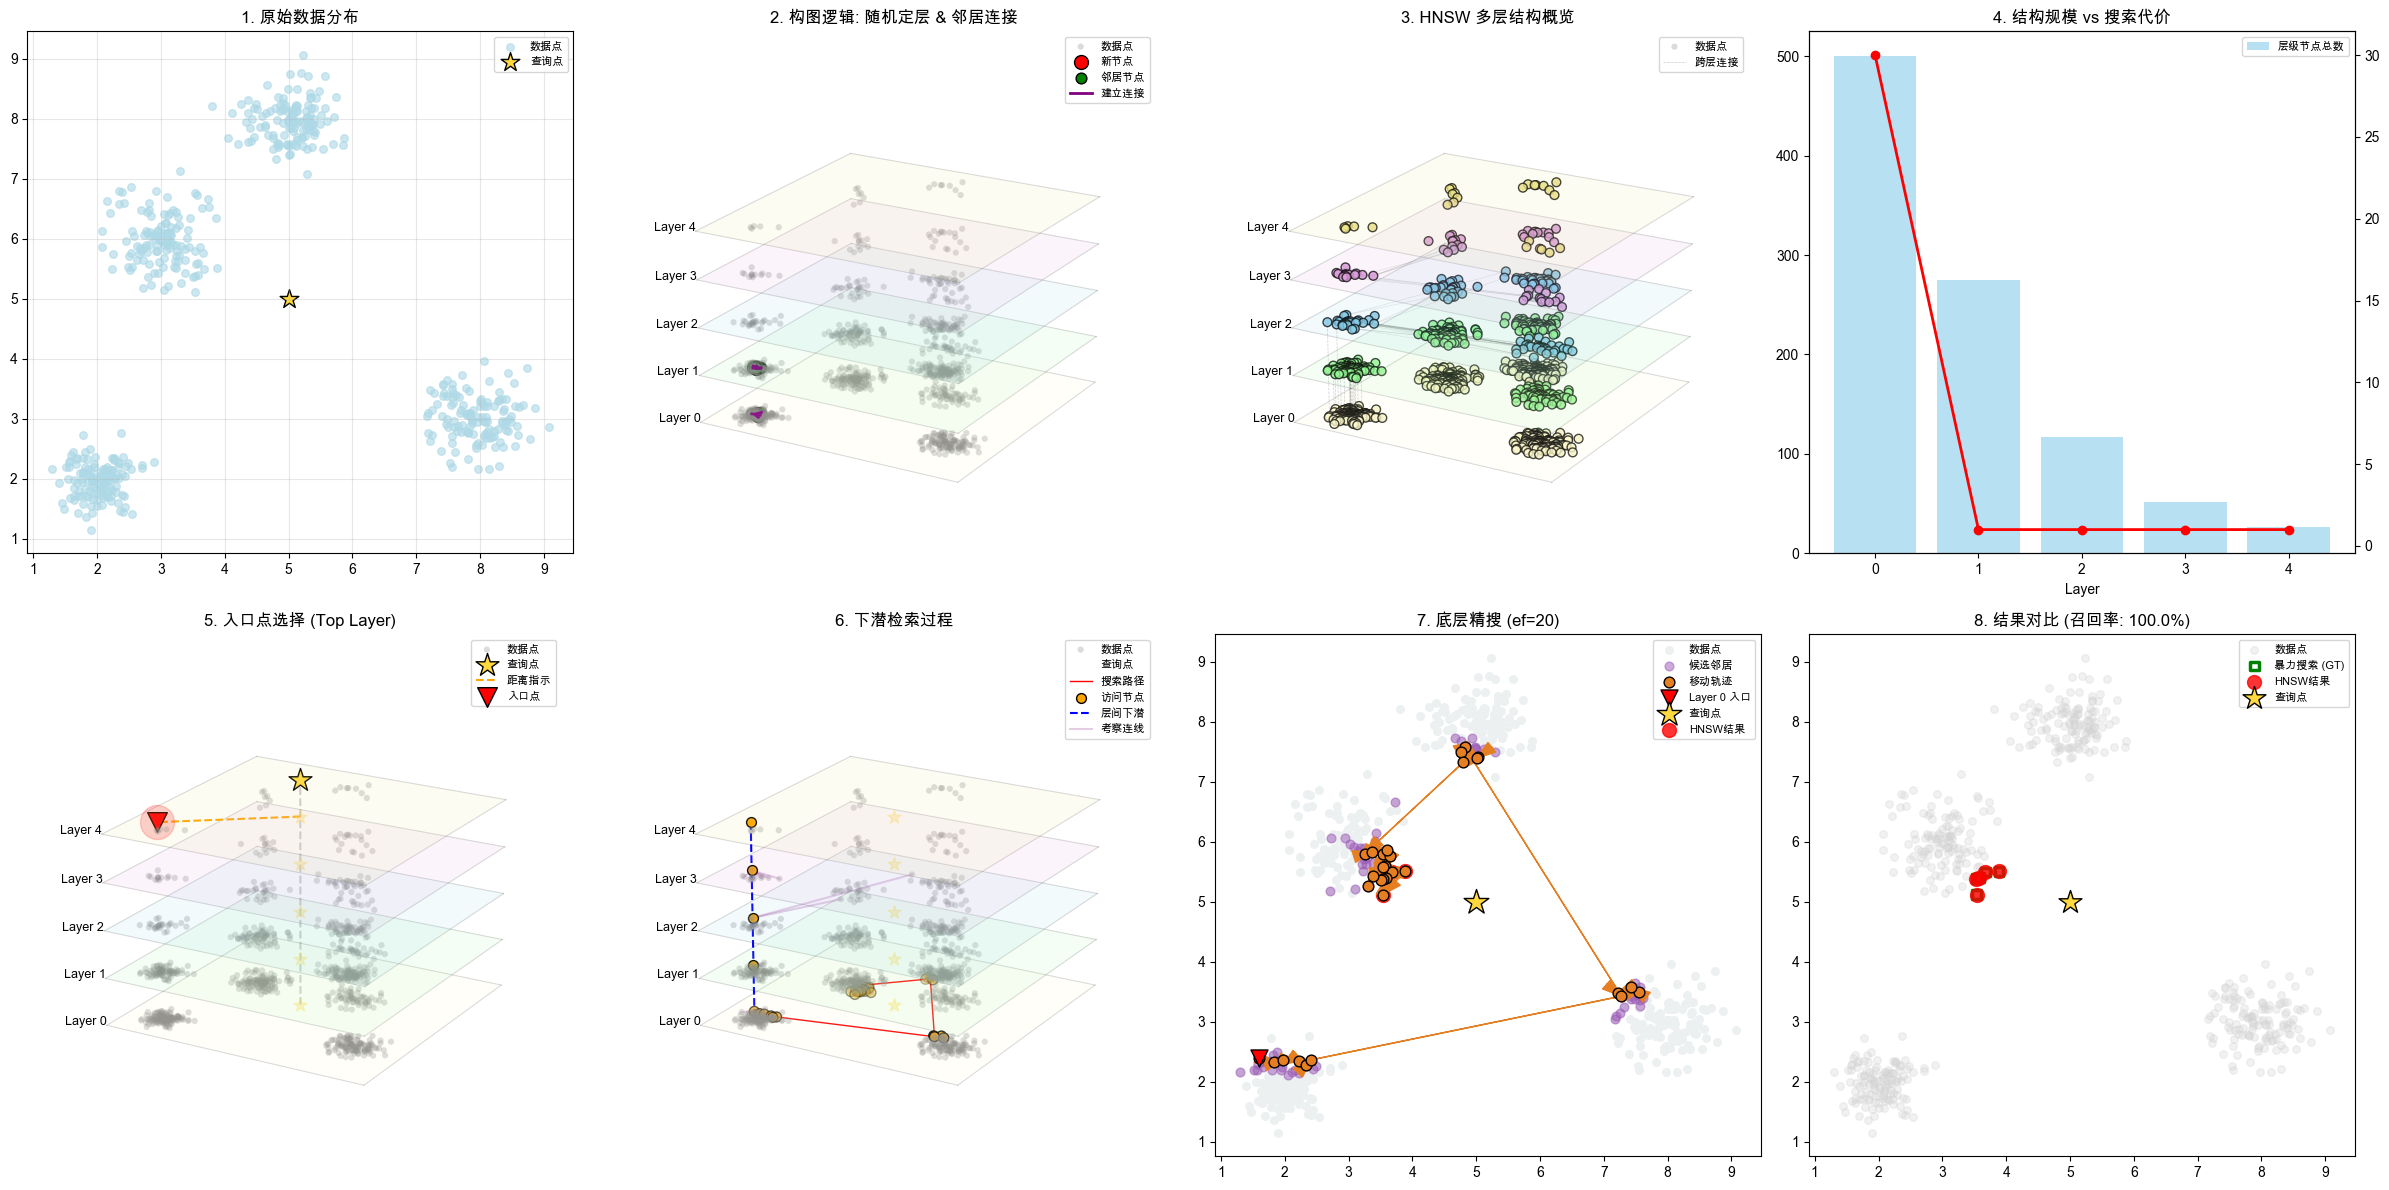

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.metrics.pairwise import euclidean_distances
import time

# --- 1. 数据生成 ---

def generate_sample_data(n_samples=200, dim=2):
    """生成示例数据：四个分离的高斯分布簇"""
    clusters = []
    
    # 创建四个簇
    cluster1 = np.random.normal(loc=[2, 2], scale=0.3, size=(n_samples//4, dim))
    cluster2 = np.random.normal(loc=[8, 3], scale=0.4, size=(n_samples//4, dim))  
    cluster3 = np.random.normal(loc=[5, 8], scale=0.35, size=(n_samples//4, dim))
    cluster4 = np.random.normal(loc=[3, 6], scale=0.4, size=(n_samples - 3*(n_samples//4), dim))
    
    data = np.vstack([cluster1, cluster2, cluster3, cluster4])
    return data

# --- 2. 可视化部分 ---

def _sort_legend(ax):
    """自动去重并保持绘图顺序"""
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize=8)

def _draw_3d_base(ax, hnsw, data, layers, h_gap, query=None):
    """3D视图通用底座"""
    z_max = (max(layers) * h_gap) + 2.0 if layers else 10
    ax.set_axis_off()
    ax.view_init(elev=20, azim=-60)
    ax.set_zlim(0, z_max)
    
    x_min, x_max = data[:, 0].min() - 0.5, data[:, 0].max() + 0.5
    y_min, y_max = data[:, 1].min() - 0.5, data[:, 1].max() + 0.5
    
    # 简单的颜色列表，用于区分层级
    layer_colors = ['#FFFACD', '#98FB98', '#87CEEB', '#DDA0DD', '#F0E68C']
    
    for l in layers:
        z = l * h_gap
        color = layer_colors[l % len(layer_colors)]
        # 平面
        corners = [[x_min, y_min, z], [x_max, y_min, z], [x_max, y_max, z], [x_min, y_max, z]]
        poly = Poly3DCollection([corners], alpha=0.1, facecolor=color)
        ax.add_collection3d(poly)
        # 边框
        for i in range(4):
            ax.plot([corners[i][0], corners[(i+1)%4][0]], [corners[i][1], corners[(i+1)%4][1]], [z, z], 'k-', alpha=0.15, lw=0.8)
        ax.text(x_min, y_min, z, f'Layer {l}', fontsize=9, fontweight='bold', ha='right')
        # 节点
        nodes = list(hnsw.layers[l].keys())
        if nodes:
            pts = data[nodes]
            ax.scatter(pts[:, 0], pts[:, 1], z, c='#888888', s=20, alpha=0.3, edgecolors='none', label='数据点')
        # 查询点投影
        if query is not None:
            ax.scatter(query[0], query[1], z, c='#FFD93D', marker='*', s=100, alpha=0.3, label=None)

# --- 分步绘图函数 ---

def _plot_step_1(ax, data, query):
    """步骤1：绘制原始数据分布"""
    ax.scatter(data[:, 0], data[:, 1], c='lightblue', alpha=0.6, s=30, label='数据点')
    if query is not None: ax.scatter(query[0], query[1], c='#FFD93D', marker='*', s=200, edgecolors='black', label='查询点')
    ax.set_title('1. 原始数据分布'); ax.grid(True, alpha=0.3)

def _plot_step_2(ax, hnsw, data, layers, h_gap, node_levels):
    """步骤2：展示构图逻辑（随机定层 & 邻居连接）"""
    _draw_3d_base(ax, hnsw, data, layers, h_gap)
    target = next((n for n, ls in node_levels.items() if len(ls) >= 2), list(node_levels.keys())[0])
    levels = node_levels.get(target, [])
    for l in layers:
        if l in levels:
            z = l * h_gap
            pt = data[target]
            ax.scatter(pt[0], pt[1], z, c='red', s=100, edgecolors='black', zorder=10, label='新节点')
            nbs = hnsw.layers[l].get(target, [])
            if nbs:
                nb_pts = data[nbs]
                ax.scatter(nb_pts[:, 0], nb_pts[:, 1], z, c='green', s=60, edgecolors='black', zorder=9, label='邻居节点')
                for nb in nb_pts: ax.plot([pt[0], nb[0]], [pt[1], nb[1]], [z, z], c='purple', linewidth=2, zorder=8, label='建立连接')
    ax.set_title('2. 构图逻辑: 随机定层 & 邻居连接')

def _plot_step_3(ax, hnsw, data, layers, h_gap, node_levels):
    """步骤3：HNSW 多层结构概览"""
    _draw_3d_base(ax, hnsw, data, layers, h_gap)
    layer_colors = ['#FFFACD', '#98FB98', '#87CEEB', '#DDA0DD', '#F0E68C']
    for l in layers:
        z = l * h_gap
        nodes = list(hnsw.layers[l].keys())
        if nodes:
            color = layer_colors[l % len(layer_colors)]
            ax.scatter(data[nodes, 0], data[nodes, 1], z, c=[color], edgecolors='black', s=40, alpha=0.8)
            for n in nodes[:20]:
                for nb in hnsw.layers[l][n]:
                    ax.plot([data[n][0], data[nb][0]], [data[n][1], data[nb][1]], [z, z], c='gray', alpha=0.2, lw=0.5)
    for n, ls in list(node_levels.items())[:30]:
        if len(ls) > 1:
            pt = data[n]
            ax.plot([pt[0], pt[0]], [pt[1], pt[1]], [min(ls)*h_gap, max(ls)*h_gap], 'k--', alpha=0.2, lw=0.5, label='跨层连接')
    ax.set_title('3. HNSW 多层结构概览')

def _plot_step_4(ax, hnsw, layers, path):
    """步骤4：分析结构规模与搜索代价"""
    counts = [len(hnsw.layers[l]) for l in layers]
    costs = [0] * len(layers)
    if path:
        for l, p in path.items():
            if l in layers: costs[layers.index(l)] = len(p)
    ax.bar(layers, counts, color='skyblue', alpha=0.6, label='层级节点总数')
    ax2 = ax.twinx()
    ax2.plot(layers, costs, 'r-o', lw=2, label='实际访问节点数')
    ax.set_title('4. 结构规模 vs 搜索代价'); ax.set_xlabel('Layer')
    lines, labels = ax.get_legend_handles_labels()
    l2, lb2 = ax2.get_legend_handles_labels()
    ax.legend(lines+l2, labels+lb2, loc='upper right')

def _plot_step_5(ax, hnsw, data, layers, h_gap, query):
    """步骤5：展示顶层入口点选择"""
    _draw_3d_base(ax, hnsw, data, layers, h_gap, query)
    z_top = max(layers) * h_gap
    entry = data[hnsw.entry_point]
    if query is not None:
        ax.scatter(query[0], query[1], z_top+1.5, c='#FFD93D', marker='*', s=300, edgecolors='black', zorder=20, label='查询点')
        ax.plot([query[0], query[0]], [query[1], query[1]], [0, z_top+1.5], 'k--', alpha=0.2)
        ax.plot([query[0], entry[0]], [query[1], entry[1]], [z_top, z_top], c='orange', ls='--', label='距离指示')
    ax.scatter(entry[0], entry[1], z_top, c='red', marker='v', edgecolors='black', s=200, zorder=20, label='入口点')
    ax.scatter(entry[0], entry[1], z_top, c='red', s=600, alpha=0.2)
    ax.set_title('5. 入口点选择 (Top Layer)')

def _plot_step_6(ax, hnsw, data, layers, h_gap, query, path):
    """步骤6：演示下潜检索过程"""
    _draw_3d_base(ax, hnsw, data, layers, h_gap, query)
    if path and query is not None:
        ax.scatter(query[0], query[1], 0, c='#FFD93D', marker='*', s=0, alpha=0, label='查询点') # Legend hack
        for l, p in path.items():
            z = l * h_gap
            pts = data[p]
            ax.plot(pts[:,0], pts[:,1], [z]*len(pts), c='red', lw=2 if l>0 else 1, label='搜索路径')
            ax.scatter(pts[:,0], pts[:,1], z, c='orange', s=50, edgecolors='black', label='访问节点')
            for n in p[:3]:
                for nb in hnsw.layers[l][n]:
                    nb_pt = data[nb]
                    ax.plot([data[n][0], nb_pt[0]], [data[n][1], nb_pt[1]], [z, z], c='purple', alpha=0.2, label='考察连线')
            if l > 0 and (l-1) in path:
                prev = data[path[l-1][0]]
                ax.plot([pts[-1,0], prev[0]], [pts[-1,1], prev[1]], [z, z-h_gap], c='blue', ls='--', label='层间下潜')
    ax.set_title('6. 下潜检索过程')

def _plot_step_7(ax, hnsw, data, query, path, results, ef=20):
    """步骤7：底层精确搜索 (Layer 0)"""
    l0_nodes = list(hnsw.layers[0].keys())
    ax.scatter(data[l0_nodes, 0], data[l0_nodes, 1], c='#ecf0f1', s=30, label='数据点')
    if path and 0 in path:
        p = path[0]; p_pts = data[p]
        inspected = {nb for n in p for nb in hnsw.layers[0][n]} - set(p)
        if inspected:
            ins_pts = data[list(inspected)]
            ax.scatter(ins_pts[:, 0], ins_pts[:, 1], c='#9b59b6', s=40, alpha=0.5, label='候选邻居')
        for i in range(len(p_pts)-1):
            ax.arrow(p_pts[i,0], p_pts[i,1], p_pts[i+1,0]-p_pts[i,0], p_pts[i+1,1]-p_pts[i,1],
                     head_width=0.2, fc='#e67e22', ec='#e67e22', length_includes_head=True, zorder=5)
        ax.scatter(p_pts[:,0], p_pts[:,1], c='#e67e22', s=60, edgecolors='black', label='移动轨迹', zorder=6)
        ax.scatter(p_pts[0,0], p_pts[0,1], c='red', marker='v', edgecolors='black', s=150, label='Layer 0 入口', zorder=10)
    if query is not None: ax.scatter(query[0], query[1], c='#FFD93D', marker='*', edgecolors='black', s=350, label='查询点')
    if results:
        res_pts = data[[r[0] for r in results]]
        ax.scatter(res_pts[:, 0], res_pts[:, 1], c='red', s=100, marker='o', alpha=0.8, label='HNSW结果')
    ax.set_title(f'7. 底层精搜 (ef={ef})')

def _plot_step_8(ax, data, query, results):
    """步骤8：结果对比与召回率分析"""
    if not results or query is None: return
    k = len(results)
    dists = euclidean_distances([query], data)[0]
    gt_idx = np.argsort(dists)[:k]
    recall = len(set(gt_idx) & set([r[0] for r in results])) / k
    ax.scatter(data[:, 0], data[:, 1], c='lightgray', s=30, alpha=0.3, label='数据点')
    ax.scatter(data[gt_idx, 0], data[gt_idx, 1], edgecolors='green', facecolors='none', linewidth=2.5, marker='s', label='暴力搜索 (GT)')
    res_pts = data[[r[0] for r in results]]
    ax.scatter(res_pts[:, 0], res_pts[:, 1], c='red', s=100, marker='o', alpha=0.8, label='HNSW结果')
    ax.scatter(query[0], query[1], c='#FFD93D', marker='*', edgecolors='black', s=300, label='查询点')
    missed = set(gt_idx) - set([r[0] for r in results])
    for idx in missed:
        pt = data[idx]
        ax.plot([query[0], pt[0]], [query[1], pt[1]], c='red', ls='--', alpha=0.6)
        ax.text(pt[0], pt[1], "漏检", color='red', fontweight='bold')
    ax.set_title(f'8. 结果对比 (召回率: {recall:.1%})')

def visualize_hnsw(hnsw, query_point=None, results=None, search_path=None):
    """简化后的可视化入口函数"""
    if not hnsw.data_points: return
    data = np.array(hnsw.data_points)
    layers = sorted([l for l in range(hnsw.max_layers) if hnsw.layers[l]])
    node_levels = {}
    for l in layers:
        for n in hnsw.layers[l]: node_levels.setdefault(n, []).append(l)
    h_gap = 2.0
    
    fig = plt.figure(figsize=(24, 12))
    layout = [(1, False), (2, True), (3, True), (4, False), (5, True), (6, True), (7, False), (8, False)]
    axes = [fig.add_subplot(2, 4, i, projection='3d' if is3d else None) for i, is3d in layout]
    
    _plot_step_1(axes[0], data, query_point)
    _plot_step_2(axes[1], hnsw, data, layers, h_gap, node_levels)
    _plot_step_3(axes[2], hnsw, data, layers, h_gap, node_levels)
    _plot_step_4(axes[3], hnsw, layers, search_path)
    _plot_step_5(axes[4], hnsw, data, layers, h_gap, query_point)
    _plot_step_6(axes[5], hnsw, data, layers, h_gap, query_point, search_path)
    _plot_step_7(axes[6], hnsw, data, query_point, search_path, results)
    _plot_step_8(axes[7], data, query_point, results)
    
    for ax in axes: _sort_legend(ax)
    plt.tight_layout(); plt.show()

# --- 3. 性能演示 ---

def demonstrate_hnsw_performance():
    """演示HNSW性能对比"""
    print("=" * 60)
    print("HNSW算法性能演示")
    print("=" * 60)
    
    # 生成测试数据
    data = generate_sample_data(500, 2)
    print(f"生成{len(data)}个二维数据点")
    
    # 创建HNSW索引
    hnsw = SimpleHNSW(max_elements=1000, M=10, ef_construction=50, max_layers=5)
    
    # 批量添加数据
    print("构建HNSW索引...")
    start_time = time.time()
    for i, point in enumerate(data):
        hnsw.add_point(point)
        if (i + 1) % 100 == 0:
            print(f"已添加{i + 1}个点")
    
    construction_time = time.time() - start_time
    print(f"HNSW索引构建完成，耗时: {construction_time:.4f}秒")
    
    # 选择查询点
    query_point = np.array([5.0, 5.0])
    print(f"\n查询点: {query_point}")
    
    # 使用HNSW搜索
    start_time = time.time()
    hnsw_results, search_path = hnsw.search_with_path(query_point, k=5, ef_search=30)
    hnsw_time = time.time() - start_time
    
    # 暴力搜索作为基准
    start_time = time.time()
    distances = euclidean_distances([query_point], data)[0]
    bf_indices = np.argsort(distances)[:5]
    bf_distances = distances[bf_indices]
    bf_time = time.time() - start_time
    
    # 显示结果对比
    print(f"\n搜索结果对比:")
    print(f"HNSW搜索 - 找到{len(hnsw_results)}个最近邻, 耗时: {hnsw_time:.6f}秒")
    print(f"暴力搜索 - 找到{len(bf_indices)}个最近邻, 耗时: {bf_time:.6f}秒")
    
    print(f"\n速度提升: {bf_time/hnsw_time:.2f}倍")
    
    print(f"\nHNSW结果索引: {[idx for idx, _ in hnsw_results]}")
    print(f"HNSW结果距离: {[dist for _, dist in hnsw_results]}")
    print(f"暴力搜索结果索引: {bf_indices}")
    print(f"暴力搜索结果距离: {bf_distances}")
    
    # 检查召回率
    hnsw_indices_set = set(idx for idx, _ in hnsw_results)
    bf_indices_set = set(bf_indices)
    intersection = hnsw_indices_set & bf_indices_set
    recall = len(intersection) / len(bf_indices_set)
    print(f"召回率: {recall:.2%} ({len(intersection)}/{len(bf_indices_set)})")
    
    return hnsw, data, query_point, hnsw_results, bf_indices, search_path

# 1. 运行标准演示
hnsw, data, query, hnsw_results, bf_results, search_path = demonstrate_hnsw_performance()

# 2. 调用可视化
visualize_hnsw(hnsw, query, hnsw_results, search_path)

### 3.4参数影响分析

In [4]:
def analyze_hnsw_parameters():
    """分析HNSW参数对性能的影响"""
    data = generate_sample_data(1000, 2)
    query = np.array([5.0, 5.0])
    
    # 测试不同参数组合
    parameter_combinations = [
        {'M': 5, 'ef_construction': 30, 'ef_search': 20},
        {'M': 10, 'ef_construction': 50, 'ef_search': 30},
        {'M': 15, 'ef_construction': 100, 'ef_search': 50}
    ]
    
    results = []
    
    for i, params in enumerate(parameter_combinations):
        print(f"\n测试参数组合 {i+1}: M={params['M']}, ef_construction={params['ef_construction']}")
        
        # 构建HNSW索引
        hnsw = SimpleHNSW(max_elements=2000, M=params['M'], 
                         ef_construction=params['ef_construction'], max_layers=6)
        
        start_time = time.time()
        for point in data:
            hnsw.add_point(point)
        build_time = time.time() - start_time
        
        # 搜索
        start_time = time.time()
        hnsw_results = hnsw.search(query, k=5, ef_search=params['ef_search'])
        search_time = time.time() - start_time
        
        # 计算召回率
        distances = euclidean_distances([query], data)[0]
        bf_indices = np.argsort(distances)[:5]
        hnsw_indices_set = set(idx for idx, _ in hnsw_results)
        recall = len(hnsw_indices_set & set(bf_indices)) / 5
        
        results.append({
            'params': params,
            'build_time': build_time,
            'search_time': search_time,
            'recall': recall
        })
        
        print(f"构建时间: {build_time:.4f}秒, 搜索时间: {search_time:.6f}秒, 召回率: {recall:.2%}")
    
    return results

# 运行参数分析
param_results = analyze_hnsw_parameters()

试参数组合 1: M=5, ef_construction=30
构建时间: 1.2516秒, 搜索时间: 0.000374秒, 召回率: 0.00%

测试参数组合 2: M=10, ef_construction=50
构建时间: 3.2875秒, 搜索时间: 0.000824秒, 召回率: 100.00%

测试参数组合 3: M=15, ef_construction=100
构建时间: 3.8578秒, 搜索时间: 0.001488秒, 召回率: 100.00%


输出结果

**核心参数的作用与结果分析**

首先，理解两个核心参数的作用至关重要：

- M（最大连接数）：决定了图中每个节点可以和多少个邻居建立连接。M值越大，图的连通性越好，导航路径越多，但也会使索引更复杂、更占内存。

- ef_construction（构建时候选集大小）：控制着在插入一个新节点时，算法会在每一层探索多少个候选邻居来寻找最佳连接。此值越大，构建出的图质量通常越高，搜索精度越有保障，但索引的构建时间也会相应增加

现在我来尝试分析一下结果：

1. **组合1 (`M=5, ef_construction=30`)：构建最快，但召回率崩溃**
   - 这是典型的参数设置**过于激进**导致的问题。过小的 `M`和 `ef_construction`使得构建出的图结构**连通性极差**。搜索时，算法可能迅速陷入局部最优解而无法找到真实的最近邻，从而导致召回率为0。虽然它的构建和搜索速度最快，但无法返回正确结果，这个组合在实际应用中是**不可用**的。
2. **组合2 (`M=10, ef_construction=50`)：性能的“甜蜜点”**
   - 此组合在**构建时间、搜索速度和召回率**之间取得了极佳的平衡。它将 `M`和 `ef_construction`提升到合理水平，成功构建出一个高质量的图结构，实现了100%的召回率。其搜索速度依然非常快，仅比组合1慢约0.00045秒，这个时间差对于大多数应用来说微不足道，却换来了结果准确性的质的飞跃。
3. **组合3 (`M=15, ef_construction=100`)：精度优先，资源消耗增大**
   - 进一步增大参数带来了**边际效益递减**。召回率维持在100%，但构建时间和搜索时间都有显著增加。这是因为算法需要处理更多的连接和候选点。这个组合适用于对**召回率有极致要求**且可以接受稍长延迟的场景